Looking for a EEG stream...
Started acquiring data.
Looking for a Markers stream...
Can't find Markers stream.
Start recording at time t=1627844456.491
Time correction:  1.0199961252510548e-05
Time correction:  -3.32500203512609e-05
Done - wrote file: ../Collected_Data/RawEEG/control/control_var1_6_raw.csv
Recording has ended


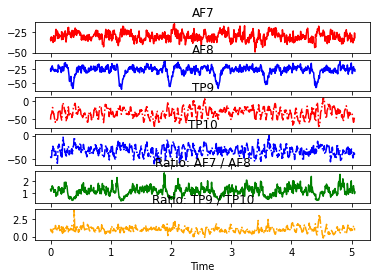

In [76]:
# Record and format Muse 2 data

from muselsl import record
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

action = "control"
file = action + "_var1_6"
folder = "../Collected_Data/"
input_file = folder+"RawEEG/"+ action + "/" + file + "_raw.csv"
output_file = folder+"FormattedEEG/" + action + "/" + file + "_formatted.csv"

# Note: an existing Muse LSL stream is required
record(6, input_file)
# Note: Recording is synchronous, so code here will not execute until the stream has been closed
print('Recording has ended')

# Read, format, and save recorded data
#plt.rcParams['figure.figsize'] = [10, 8]
#plt.rcParams['figure.dpi'] = 600 # 200 e.g. is really fine, but slower
df = pd.read_csv(input_file, usecols=[1,2,3,4,5,6], header=0, names=["TP9", "AF7", "AF8","TP10", "Time", "Offset"])
df["Time"] = df["Time"] + df["Offset"]
df["Time"] = df["Time"] - df["Time"].iloc[0]
del df["Offset"]

# Plot formatted data
fig,(graph0, graph1, graph2, graph3, graph4, graph5) = plt.subplots(nrows = 6, sharex = True)
line0, = graph0.plot(df["Time"], df["AF7"], color = "red", linestyle = "solid")
line1, = graph1.plot(df["Time"], df["AF8"], color = "blue", linestyle = "solid")
line2, =  graph2.plot(df["Time"], df["TP9"], color = "red", linestyle = "dashdot")
line3, = graph3.plot(df["Time"], df["TP10"], color = "blue", linestyle = "dashdot")
line4, = graph4.plot(df["Time"], (df["AF7"]/df["AF8"]), color = "green", linestyle = "solid")
line5, = graph5.plot(df["Time"], (df["TP9"]/df["TP10"]), color = "orange", linestyle = "dashdot")

graph0.title.set_text('AF7')
graph1.title.set_text('AF8')
graph2.title.set_text('TP9')
graph3.title.set_text('TP10')
graph4.title.set_text('Ratio: AF7 / AF8')
graph5.title.set_text('Ratio: TP9 / TP10')

#graph4.legend((line0, line1, line2, line3), ("AF7", "AF8", "TP9", "TP10"), loc='lower right')
plt.xlabel('Time')
plt.show()

# stores 5s time series in output_file 
del df["Time"]
df.to_csv(output_file)




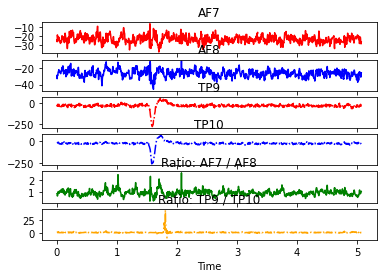

In [79]:
file = "control_var3_3"
folder = "../Collected_Data/"
input_file = folder+"RawEEG/control/" + file + "_raw.csv"

df = pd.read_csv(input_file, usecols=[1,2,3,4,5,6], header=0, names=["TP9", "AF7", "AF8","TP10", "Time", "Offset"])
df["Time"] = df["Time"] + df["Offset"] - df["Time"].iloc[0]
del df["Offset"]

# Plot formatted data
fig,(graph0, graph1, graph2, graph3, graph4, graph5) = plt.subplots(nrows = 6, sharex = True)
line0, = graph0.plot(df["Time"], df["AF7"], color = "red", linestyle = "solid")
line1, = graph1.plot(df["Time"], df["AF8"], color = "blue", linestyle = "solid")
line2, =  graph2.plot(df["Time"], df["TP9"], color = "red", linestyle = "dashdot")
line3, = graph3.plot(df["Time"], df["TP10"], color = "blue", linestyle = "dashdot")
line4, = graph4.plot(df["Time"], (df["AF7"]/df["AF8"]), color = "green", linestyle = "solid")
line5, = graph5.plot(df["Time"], (df["TP9"]/df["TP10"]), color = "orange", linestyle = "dashdot")

graph0.title.set_text('AF7')
graph1.title.set_text('AF8')
graph2.title.set_text('TP9')
graph3.title.set_text('TP10')
graph4.title.set_text('Ratio: AF7 / AF8')
graph5.title.set_text('Ratio: TP9 / TP10')

#graph4.legend((line0, line1, line2, line3), ("AF7", "AF8", "TP9", "TP10"), loc='lower right')
plt.xlabel('Time')
plt.show()

In [ ]:

from pylsl import StreamInlet, resolve_stream
import matplotlib.pyplot as plt

import mne
from mne.datasets import sample
from mne.io import read_raw_fif

from mne_realtime import LSLClient, MockLSLStream


# first resolve an EEG stream on the lab network
print("looking for an EEG stream...")
#streams = resolve_stream('type', 'EEG')

# create a new inlet to read from the stream
#inlet = StreamInlet(streams[0])

info = mne.create_info(ch_names=['TP9', 'AF7', 'AF8', 'TP10', 'TimeBase', 'TimeOffset'], sfreq="250", ch_types=['eeg', 'eeg','eeg','eeg','misc','misc'])

# For this example, let's use the mock LSL stream.
_, ax = plt.subplots(1)
n_epochs = 10
unitType = dict(eeg='uV', misc=None)
with LSLClient(info, host="LSLBridge", wait_max=10) as client:
    client_info = client.get_measurement_info()
    sfreq = int(client_info['sfreq'])

    # let's observe ten seconds of data
    for ii in range(n_epochs):
        print('Got epoch %d/%d' % (ii + 1, n_epochs))
        plt.cla()
        epoch = client.get_data_as_epoch(n_samples=sfreq)
        print(epoch.get_data(picks="eeg", units=unitType, item=np.arange(12)))
        epoch.average().plot(axes=ax)
        plt.pause(1.)
    plt.draw()
print('Streams closed')



In [129]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.svm import TimeSeriesSVC
            
np_df = df.to_numpy()
np_df = np_df[250:1000]
np_df = np_df.T
print(np_df.shape)
    
preprocess = TimeSeriesScalerMeanVariance(mu = 0, std=1)
np_df_processed = preprocess.fit_transform(np_df)

print(np_df_processed.shape)
print(np_df_processed)

model = TimeSeriesSVC(kernel="rbf",gamma="auto", probability=True, random_state=1)

(4, 750)
(4, 750, 1)
[[[ 0.43879952]
  [-0.1434321 ]
  [-0.34890705]
  ...
  [-0.21192375]
  [ 0.28466701]
  [-0.0920546 ]]

 [[-0.40612069]
  [-0.36439725]
  [-0.44784413]
  ...
  [-0.15560905]
  [ 0.63756381]
  [ 0.67928725]]

 [[-0.42617824]
  [-0.91037161]
  [-0.35173389]
  ...
  [ 1.58496333]
  [ 0.76554155]
  [ 1.24973493]]

 [[ 0.71555005]
  [ 0.18909111]
  [-0.12683816]
  ...
  [-1.10082764]
  [ 0.11010879]
  [-0.15314763]]]


In [18]:
import numpy as np
import pandas as pd

# control = 0, left = 1, right = 2

def read_all_csvs():
    folder = "../Collected_Data/FormattedEEG/"
    types = ["control", "left_blink", "right_blink"]
    csv_paths = np.array([["left_blink_var1", 1], ["left_blink_var2", 1], ["right_blink_var1", 2], ["right_blink_var2", 2], ["control_var1", 0], ["control_var2", 0]])
    
    output_x = []
    output_y = []
    
    for path in csv_paths:
        for i in range(1, 11):
            if path[0].find("control") != -1 and i == 6:
                break;
            cur_path = folder + types[int(path[1])] + "/" + path[0] + "_" + str(i) + "_" + "formatted.csv"
            #print(cur_path)
            input_data = pd.read_csv(cur_path, header = 0, usecols=[1, 2, 3, 4])
            #print(input_data.head())
            X = input_data.to_numpy()[250:1000]
            X = X.T
            # print(X)
            y = path[1] 
            output_x.append(X)
            output_y.append(y)
    
    output_x = np.array(output_x) 
    output_y = np.array(output_y)
    print(output_x.shape, output_y.shape)
    return output_x, output_y

read_all_csvs()

(50, 4, 750) (50,)


(array([[[-12.695, -12.695, -16.113, ..., -32.715, -11.23 , -27.832],
         [-26.367, -29.785, -27.344, ...,  15.137, -26.367, -41.992],
         [-31.25 , -31.25 , -27.344, ..., -27.832, -33.691, -39.062],
         [-21.484, -12.207,  -8.301, ..., -27.832,  -3.906,  -8.789]],
 
        [[-17.09 , -13.184, -23.926, ..., -25.391, -21.484, -39.062],
         [-33.203, -29.297, -28.32 , ..., -45.41 , -36.621, -46.875],
         [-32.227, -32.715, -36.133, ..., -39.062, -32.715, -36.621],
         [-31.25 , -33.203, -35.645, ..., -34.18 , -34.18 , -42.969]],
 
        [[-51.27 , -54.199, -33.691, ..., -62.5  , -36.621, -10.742],
         [-20.996, -18.066, -14.16 , ..., -38.574, -45.41 , -63.965],
         [-29.297, -53.223, -57.129, ..., -31.25 ,  -6.348,  -9.766],
         [-40.039, -42.969, -36.133, ..., -42.969, -26.855,  -8.301]],
 
        ...,
 
        [[-54.688, -48.828, -25.391, ..., -54.688, -43.945, -36.621],
         [-26.367, -32.715, -28.32 , ..., -27.832, -29.297, -27.34